##### 들어가기 전에...

이 주피터 노트북은 보고서의 형태를 띄고 있습니다. 원본을 보고 싶으시면 [원본 노트북](https://colab.research.google.com/drive/1m4Sia9G3wn6CoXdi6p--kPdgzGnVymHr?usp=sharing)을 참고해주세요. 원본 노트북을 먼저 작성한 뒤 복사해 이 보고서 노트북을 작성했습니다.

이하 코드는 마지막 부분 `matplotlib`에서 한글을 출력하기 위해 글꼴을 설정합니다.

In [ ]:
import matplotlib.font_manager as fm  # 폰트 관련 용도
import matplotlib.pyplot as plt

!apt-get update -qq
!apt-get install fonts-nanum* -qq

%config InlineBackend.figure_format = 'retina'
path = '/usr/share/fonts/truetype/nanum/NanumBrush.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=13).get_name()
plt.rc('font', family=font_name)
fm._rebuild()

# 텐서플로우를 이용한 한글 자음 인식 인공지능 만들기

`모두의 인공지능 with 파이썬(이영호, 길벗)`에서 텐서플로우를 이용해 MNIST 데이터셋을 학습시켜 보았다. 0부터 9까지의 28x28 이미지와 정답이 주어지는, 지도 학습(Supervised Learning) 중에 다중 분류(Multiclass Classification)다. 그렇다면 코드를 조금만 변형하면 아름다운 우리 글자, 한글도 인식할 수 있지 않을까? 0~9의 숫자는 10개이어서 출력층의 개수가 10개였지만 한글이라면(자모 각각으로 보면) 14+10=24개의 출력층을 갖도록 수정하면 될 것이다. 바로 시작해보겠다.

## 데이터셋

이 노트북에서 사용하는 데이터셋은 `kaggle.com`에 있는 [Handwritten Hangul Characters](https://www.kaggle.com/wayperwayp/hangulkorean-characters/version/1)를 사용한다. 한글 자모별로 약 80개의 이미지가 있는 데이터셋이다. MNIST 데이터셋과 마찬가지로 28x28 픽셀인 흑백 이미지로 이루어져 있고 `bb_3_0.jpg`와 같이 파일 이름에 레이블이 있다(이 경우에는 bb=ㅃ).

`kaggle` 데이터셋을 콜랩으로 다운로드하기 위해 `kaggle API`를 이용한다. 진행하기 위해서 Kaggle 어카운트 설정에서 API 토큰 파일(`kaggle.json`)을 먼저 내려받자. 아래 코드의 *Upload* 버튼을 누르고 `kaggle.json`을 업로드한다. 

In [ ]:
from google.colab import files
print("Please upload your kaggle.json")
files.upload()

!mkdir -p ~/.kaggle
# 유저 디렉터리로 이동
!mv kaggle.json ~/.kaggle/
# 권한 오류 방지
!chmod 600 ~/.kaggle/kaggle.json

Please upload your kaggle.json


Saving kaggle.json to kaggle.json


`kaggle.json`을 유저 디렉터리로 옮겼다. 이제 본격 다운로드다. kaggle 명령어는 콜랩에 내장되어 있다. 아래 코드는 다운 후 압축 해제한다. (콜랩에서 다운로드 시 `/content/` 아래 파일이 저장된다)

In [ ]:
!kaggle datasets download -d wayperwayp/hangulkorean-characters
!unzip -qq /content/hangulkorean-characters.zip -d /content/hangulkorean-characters

hangulkorean-characters.zip: Skipping, found more recently modified local copy (use --force to force download)
replace /content/hangulkorean-characters/hangul_characters_v1/a_0_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


## 이미지 전처리

다운받은 데이터셋은 전처리가 필요하다. MNIST 데이터셋처럼 X_train이나 Y_test가 나뉘어있지 않다. 직접 만들어주자.
`jaums`는 한글 자음 리스트다. `ㄸ` 등 데이터셋에 없어 제외된 자음도 있다. `jaums_kor`는 `jaums`와 일대일 대응된다.

In [ ]:
# 데이터셋이 저장된 경로
base_path = "/content/hangulkorean-characters/hangul_characters_v1/"

# 자음 목록 (한글, 로마자)
jaums_kor = ['ㄱ', 'ㄲ', 'ㄴ', 'ㄷ', 'ㄹ', 'ㅁ', 'ㅂ', 'ㅃ', 'ㅅ', 'ㅆ', 'ㅇ', 'ㅈ', 'ㅊ', 'ㅋ', 'ㅌ', 'ㅍ', 'ㅎ']
jaums = ['g', 'gg', 'n', 'd', 'r', 'm', 'b', 'bb', 's', 'ss', 'ng', 'j', 'ch', 'k', 't', 'p', 'h']

`glob` 모듈을 이용해 자음 이미지 경로만 가져온다. 그 다음 훈련 데이터와 시험 데이터를 나눈다. 매 18번째 이미지만(=인덱스가 18의 배수인 요소) 시험 데이터로 간주한다.

In [ ]:
import numpy as np
from glob import glob

image_paths = []
for jaum in jaums:
  image_paths += glob(base_path+jaum+"*")

image_paths = list(set(image_paths)) # 중복 제거
print(f"total {len(image_paths)} images")

# 이미지 경로 리스트를 훈련 데이터와 시험 데이터로 분리
nth = 18
paths_list = [
  image_paths[:], # 훈련 데이터 (아직 전체 데이터)
  image_paths[::nth] # 시험 데이터
]

del paths_list[0][nth-1::nth] # 훈련 데이터 중 시험 데이터를 제외

print(f"train set: {len(paths_list[0])}")
print(f"test set: {len(paths_list[1])}")

total 1360 images
train set: 1285
test set: 76


주어진 경로의 이미지를 불러오고 넘파이 배열로 변환한다. 이 과정에서 0-255인 값을 255로 나누어 0-1의 실수로 정규화한다. 
`to_categorical`을 이용해 Y 데이터(레이블)는 원-핫 인코딩으로 변환한다.

In [14]:
from PIL import Image
from tensorflow.keras.utils import to_categorical

Xs = []
Ys = []

for paths in paths_list:
  X = np.zeros((len(paths),784)).astype("float32") # 784=28*28
  Y = np.zeros((len(paths)))
  
  for i in range(len(paths)):
    answer = paths[i].split("/")[-1].split("_")[0] # 이미지 이름에서 레이블 추출
    image = np.array(Image.open(paths[i]).convert("L")) # convert("L"): 이미지를 흑백으로 변환
    image = np.reshape(image, (784)) # 28x28 픽셀을 한 줄로 변환
    X[i] = image/255 # 정규화
    Y[i] = jaums.index(answer)

  Xs.append(X)
  Ys.append(to_categorical(Y, len(jaums))) # 원-핫 인코딩

## 학습 진행

`Sequential()`을 이용해 모델을 생성한다. 자음의 개수가 약 17개 정도이니 은닉층 개수를 MNIST보다 한 층 늘렸다.
다중 분류 문제이니 손실 함수, 옵티마이저는 각각 `categorical_crossentropy`, `adam`으로 설정한다.
에폭은 30으로 설정했다.

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

X_train, X_test = Xs
Y_train, Y_test = Ys

model = Sequential()
model.add(Dense(1024, input_shape=(784,)))
model.add(Activation("relu"))
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dense(len(jaums)))
model.add(Activation("softmax"))
model.summary()

print("\n\n")

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, Y_train, epochs=30, verbose=1, batch_size=128)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              803840    
                                                                 
 activation_4 (Activation)   (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 activation_5 (Activation)   (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 activation_6 (Activation)   (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 17)               

## 시험

이제 훈련 데이터로 학습이 완료되었다. 이제 시험 데이터로 시험해보자. 

In [16]:
score = model.evaluate(X_test, Y_test)
print("Test score:", score[0])
print("Test accuracy:", score[1])

3/3 [==============================] - 0s 7ms/step - loss: 0.1546 - accuracy: 0.9474
Test score: 0.15456195175647736
Test accuracy: 0.9473684430122375


## 학습 결과 살펴보기

(이 부분은 책의 코드와 거의 유사합니다.)

정확도까지 알아보았다. 코드와 수치로만 살펴보면, 우리가 이미지를 학습하고 있다는 사실을 쉽게 잊기 마련이다. 훈련 데이터 중 모델이 정답을 맞춘 이미지(`correct_indices`)와 틀린 이미지(`incorrect_indices`)를 직접 알아보자.

In [17]:
Y_test_max = np.argmax(Y_test, axis=1) # 원-핫 인코딩 되어있는 훈련 레이블을 정답 정수만 남기기

predicted_classes = np.argmax(model.predict(X_test), axis=1) # 모델에게 예측 시키기
correct_indices = np.nonzero(predicted_classes == Y_test_max)[0] # 모델이 맞춘 이미지들만 가져오기
incorrect_indices = np.nonzero(predicted_classes != Y_test_max)[0] # 모델이 틀린 이미지들만 가져오기

이미지를 출력하기 전에... 우리는 한글을 다루기 때문에 플롯 제목에 한글이 포함된다(숫자로만 출력할 수 있지만 직관성이 떨어진다). 하지만 기본 콜랩에는 한글 글꼴이 없기 때문에 깨져서 출력된다. 이 문제를 해결하기 위해 이 노트북 맨 위에서 나눔손글씨체를 설치하고, 글꼴을 설정한 것이다. 

이제 출력해보자. 먼저 정답을 맞춘 이미지 중 9장이다.

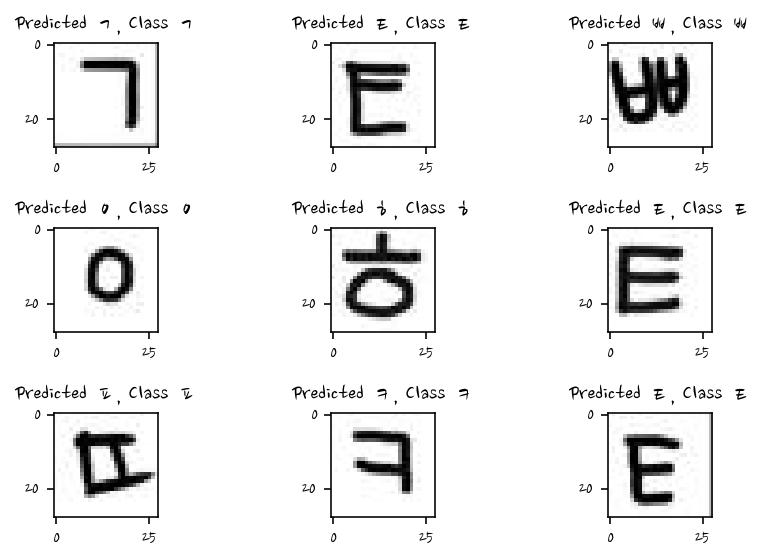

In [18]:
plt.figure()
for i in range(min(len(correct_indices), 9)): 
  plt.subplot(3,3,i+1)
  correct = correct_indices[i]
  plt.imshow(X_test[correct].reshape(28,28), cmap='gray') # 흑백으로 이미지 출력
  plt.title(f"Predicted {jaums_kor[predicted_classes[correct]]}, Class {jaums_kor[Y_test_max[correct]]}")

plt.tight_layout()

모범답안을 본 것이니 별 감흥은 없다. 그 다음 틀린 이미지들이다.

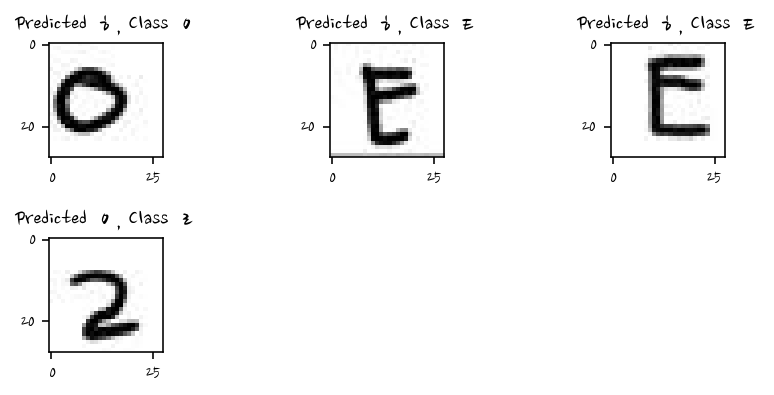

In [19]:
plt.figure()
for i in range(min(len(incorrect_indices), 9)): # 정확도 100%일 때에는, incorrect_indices 요소가 0개다. 오류 방지로 min()
  plt.subplot(3,3,i+1)
  incorrect = incorrect_indices[i]
  plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray') # 흑백으로 이미지 출력
  plt.title(f"Predicted {jaums_kor[predicted_classes[incorrect]]}, Class {jaums_kor[Y_test_max[incorrect]]}")

plt.tight_layout()

정확도가 터무니없이 높은 경우, 틀린 이미지가 0개가 나올 수 있다.

## 이미지 직접 업로드해서 예측하기

남이 만든 데이터셋만을 다루다보면 느낌이 다가오지 않는 경우가 있다. 내가 만든 데이터를 직접 넣어보자. 28x28 흑백 한글 자음 이미지를 준비하자. 이미지 이름은 `test_`로 시작해야 한다. 작성자는 포토샵을 이용해 이미지를 그렸다. 아래에서 이미지들을 업로드하자.

In [ ]:
print("Upload images. Image Name should start with 'test_'.")
files.upload()

Upload images. Image Name should start with 'test_'.


Saving test_b1.png to test_b1.png
Saving test_b2.png to test_b2.png
Saving test_b3.png to test_b3.png
Saving test_b4.png to test_b4.png
Saving test_b5.png to test_b5.png
Saving test_bb1.png to test_bb1.png
Saving test_ch1.png to test_ch1.png
Saving test_ch2.png to test_ch2.png
Saving test_g1.png to test_g1.png
Saving test_g2.png to test_g2.png
Saving test_gg1.png to test_gg1.png
Saving test_gg2.png to test_gg2.png
Saving test_j.png to test_j.png
Saving test_j2.png to test_j2.png
Saving test_m1.png to test_m1.png
Saving test_ng1.png to test_ng1.png
Saving test_p1.png to test_p1.png
Saving test_r1.png to test_r1.png
Saving test_r2.png to test_r2.png
Saving test_s1.png to test_s1.png


{'test_b1.png': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x1c\x00\x00\x00\x1c\x08\x02\x00\x00\x00\xfdoH\xc3\x00\x00\x00\tpHYs\x00\x00.#\x00\x00.#\x01x\xa5?v\x00\x00\x03\x1dIDATH\x89\xd5\x95\xbdN\xebL\x10\x86w\xed\xf5\xda\xde\xb5\x85\xe2(\x82\x86\x8a\x12\x85\x8a\x06.\x00$\nn\x80\x02\xae\x84\x96\x0b\xa0\xe5\x1a@\x08)-\x1d\x12\x01E\x14Q*\x90\x90,~\x0cX\x91\x89\x1d\xdb\xb1\xbd{\x8a\x81\x05\xe5\x87#\x1d\xf1\x15\xdf\x14V\xac\xcc>3\xf3\xce\xcc\x1aK)\xd1o\x9b\xf6\xebD\x84\x10\xf9\x873R\xca\xe1p\x98$\x89m\xdb\x8e\xe3`\x8c\x7f\x82\n!\x10B\x9a6=}!DY\x96\x84\x908\x8e[\xad\xd6\xf5\xf5\xf5\xf2\xf2\xf2\xf6\xf6v\xbd^\x9f\x12VJ)\x84\x08\xc3\xb0\xd3\xe9\xb4\xdb\xed \x08\xaa\xaa\x92\xb3\xad\xd3\xe9\xac\xac\xacPJ\x97\x96\x96\xce\xcf\xcf\x85\x10c\x0e\x1fI\xc5q|||\xbc\xbb\xbb\xbb\xb3\xb3stt\x14E\xd1\x0f\xe5\xdf\xdf\xdf\xdf\xdd\xdd\x8dF#\xdf\xf7{\xbd^Y\x96c\x0e\x1f\xd0\xd7\xd7\xd7\xd3\xd3\xd3^\xafw{{{rr\xe2\xfb\xfe\x0f\xd0\xc1`\x00 !D\x9a\xa6\x93\x0e_\x99>==UU\x05\x01\x92$\x99E\x14BdY\x06\x9e\x08!J\x

위의 데이터 전처리와 똑같은 방식으로 이미지를 정규화한다.

In [20]:
from math import floor

uploaded = glob("/content/test_*.png") + glob("/content/test_*.jpg") + glob("/content/test_*.jpeg")
uploaded.sort()
images  = np.zeros((0, 784)).astype("float32")
for u in uploaded:
  image = np.array(Image.open(u).convert("L")).astype("float32")
  image = np.reshape(image, (784))
  image /= 255

  images = np.append(images, [image], axis=0)

predicted = model.predict(images)
for i in range(len(uploaded)):
  print(f"{uploaded[i]}: {jaums_kor[np.argmax(predicted[i])]} ({floor(predicted[i][np.argmax(predicted[i])]*100)}%)")

/content/test_b1.png: ㅃ (90%)
/content/test_b2.png: ㅃ (97%)
/content/test_b3.png: ㅁ (89%)
/content/test_b4.png: ㅂ (88%)
/content/test_b5.png: ㅂ (92%)
/content/test_bb1.png: ㅃ (94%)
/content/test_ch1.png: ㅊ (90%)
/content/test_ch2.png: ㅋ (95%)
/content/test_g1.png: ㄱ (88%)
/content/test_g2.png: ㄱ (93%)
/content/test_gg1.png: ㄲ (81%)
/content/test_gg2.png: ㅈ (78%)
/content/test_j.png: ㄱ (72%)
/content/test_j2.png: ㅈ (58%)
/content/test_m1.png: ㄷ (54%)
/content/test_ng1.png: ㅇ (97%)
/content/test_p1.png: ㄷ (38%)
/content/test_r1.png: ㄹ (92%)
/content/test_r2.png: ㅍ (59%)
/content/test_s1.png: ㅅ (95%)


결과를 확인할 수 있다. 작성자가 그린 이미지는 인식률이 천차만별이었다. ㄱ와 ㅈ을 헷갈리고, ㅂ과 ㅃ을 헷갈리는 것으로 보인다. 포토샵 브러시보다 연필 도구로 그렸을 때 정답을 잘 맞췄다.

## 느낀 점 및 결론

"MNIST의 출력층 개수만 바꾸면 되겠지"라고 생각해 쉽게 시작했지만, 그리 간단하지 않았던 과정이었다. 데이터가 잘 정돈되어 있는 MNIST와 달리 레이블도 붙여야 하고, 훈련 데이터와 시험 데이터를 직접 나눠야 했다. 하지만 밑바닥부터 만들어보는 기분이라 멈추지 않고 이어갈 수 있었다. 만약 한글 이미지가 MNIST처럼 미리 정리된 데이터셋이었다면 내부 구조에 익숙해지는 데에도 시간을 썼어야 했을 것이고, 자음만 추출하거나 자음을 한글로(k, g처럼 로마자가 아닌) 나타내지 않았을 것이다.
다만 '딥러닝'과 직접적으로 관련된 부분에서 고민을 많이 했기보다는 다소 외적인 요소에 시간을 쓴 점은 아쉽다. kaggle과 콜랩의 연동이나, 콜랩 matplotlib에서 한글 글꼴 설정하기, 넘파이 배열 다루기 등이다. 모델을 다룰 때보다 막혀있는 시간이나 고민이 많았다. 하지만 데이터 분석이나 AI에 간접적이라도 관련이 있는 부분이고, 결국 해결했다는 점에서 위안을 얻는다. 사용한 데이터셋의 이미지 수가 1360개 뿐인 점도 아쉬운데, 이는 kaggle에 공개된 한글 데이터셋의 부족이 원인으로 보인다. 정확도를 더 올리기 위해서는 직접 한글을 써서 데이터셋의 수를 늘리거나 풍부한 데이터셋을 사용하는 방향으로 나아가야 할 것이다.
이러나저러나, 직접 학습할 데이터셋을 정하고, 데이터를 전처리하고, 모델을 구성하는 과정을 구상하고 프로그래밍해보고 실행하는 과정에서 많은 것을 배울 수 있었다. AI 기초 수업에서 배운 개념들을 종합적으로 적용하거나 고민해볼 수 있었다. 다음에는 앞서 말한대로 이미지 수가 훨씬 많은 데이터셋을 이용하거나, 파일을 업로드하는 게 아닌 웹 등에서 그림을 직접 그려보는 등의 개선을 할 수 있을 것이다. 아니면 배운 AI 개념을 사용헤 텐서플로우 등의 프레임워크를 이용하지 않고 직접 밑바닥부터 딥러닝 모델을 쌓아보는 경험을 해보고 싶다.

## 참고 자료

- 모두의 인공지능 with 파이썬(이영호 저, 길벗)
- [Korean font in colab](https://colab.research.google.com/github/nicewook/datascience_exercise/blob/master/korean_font_on_matplotlib.ipynb#scrollTo=uOjYIs0z1tlk)
- [캐글과 구글 Colab 연결해주기!](https://medium.com/hyunjulie/캐글과-구글-colab-연결해주기-6a274f6de81d)
- [Image Convert](https://www.pluralsight.com/guides/importing-image-data-into-numpy-arrays)
- [PIL image from binary data](https://stackoverflow.com/questions/32908639/open-pil-image-from-byte-file)
- [Colab upload files from local](https://colab.research.google.com/notebooks/io.ipynb)
